In [2]:
import os
import torch
import random
from PIL import Image
from torchvision.io import read_image
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

ModuleNotFoundError: No module named 'torch'

## Read & Check Data

In [1]:
class ISIC2018Dataset(data.Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        """
        Initialize ISIC2018Dataset.

        Args:
            img_dir (str): Directory containing images.
            annotations_file (str): Path to the CSV file containing image annotations.
            transform (callable, optional): Optional transform to be applied to the images.
        """
        self.image_labels_df = pd.read_csv(annotations_file)  # Load image annotations from CSV
        self.image_dir = img_dir  # Directory containing images
        self.transform = transform  # Image transformation function

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.image_labels_df)

    def __getitem__(self, idx):
        """
        Retrieves and preprocesses an image and its corresponding label from the dataset.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: A tuple containing the preprocessed image and its corresponding label.
        """
        img_name = self.image_labels_df.iloc[idx, 0]  # Get image name from DataFrame
        img_path = os.path.join(self.image_dir, img_name + '.jpg')  # Construct image path
        image = Image.open(img_path)  # Open image
        label = self.image_labels_df.iloc[idx, 1:].values.argmax()  # Get image label
        if self.transform:
            image = self.transform(image)  # Apply image transformation if specified
        return image, label

NameError: name 'data' is not defined

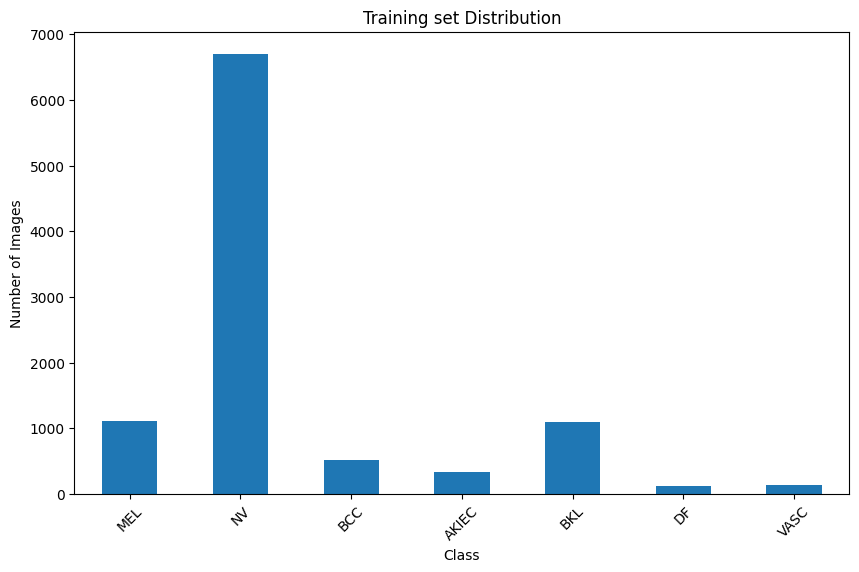

In [28]:
# Load the CSV file containing ground truth annotations
annotations_file_path = "ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"
ground_truth_df = pd.read_csv(annotations_file_path)

# Calculate the distribution of classes in the dataset
class_distribution = ground_truth_df.drop(columns=['image']).sum()

# Plot the class distribution
plt.figure(figsize=(10, 6))  # Set the figure size
class_distribution.plot(kind='bar')  # Plot the class distribution as a bar chart
plt.title('Training Set Distribution')  # Set the title of the plot
plt.xlabel('Class')  # Set the label for the x-axis
plt.ylabel('Number of Images')  # Set the label for the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

In [29]:
# Print class-wise number of images
print("The Class-wise number of images is:")
print(class_distribution)

Class-wise number of images:
MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64


### Balancing the Data

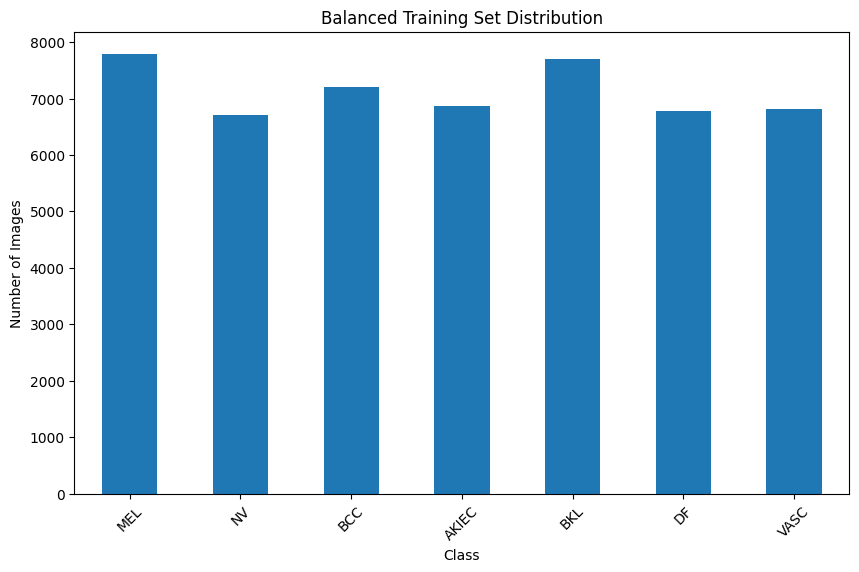

Class-wise number of images after balancing:
MEL      7791.0
NV       6705.0
BCC      7196.0
AKIEC    6867.0
BKL      7693.0
DF       6785.0
VASC     6816.0
dtype: float64


In [30]:
import math

# Define the maximum number of instances per class after oversampling
max_class_count = int(class_distribution.max())
balanced_data_indices = []

# Iterate over each class in the dataset
for class_name, count in class_distribution.items():
    # Get indices of samples belonging to the current class
    class_indices = ground_truth_df.index[ground_truth_df[class_name] == 1].tolist()
    
    # If the class count is less than the maximum class count, perform oversampling
    if count < max_class_count:
        # Calculate the oversampling factor required to balance the dataset
        oversample_factor = math.ceil(max_class_count / count)
        
        # Duplicate instances to balance the dataset
        for i in range(oversample_factor):
            balanced_data_indices.extend(class_indices)
    else:
        # If the class count is already equal to or greater than the maximum class count,
        # add all instances of the class to the balanced dataset
        balanced_data_indices.extend(class_indices)

# Create a DataFrame containing the balanced data
balanced_df = ground_truth_df.iloc[balanced_data_indices]

# Define the file path for saving the balanced data
balanced_data_file_path = "balanced_data.csv"

# Save the balanced data to a CSV file
balanced_df.to_csv(balanced_data_file_path, index=False)

# Calculate the class distribution of the balanced dataset
balanced_class_distribution = balanced_df.drop(columns=['image']).sum()

# Plot the class distribution of the balanced dataset
plt.figure(figsize=(10, 6))
balanced_class_distribution.plot(kind='bar')
plt.title('Balanced Training Set Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Print the class-wise number of images after balancing
print("Class-wise number of images after balancing:")
print(balanced_class_distribution)


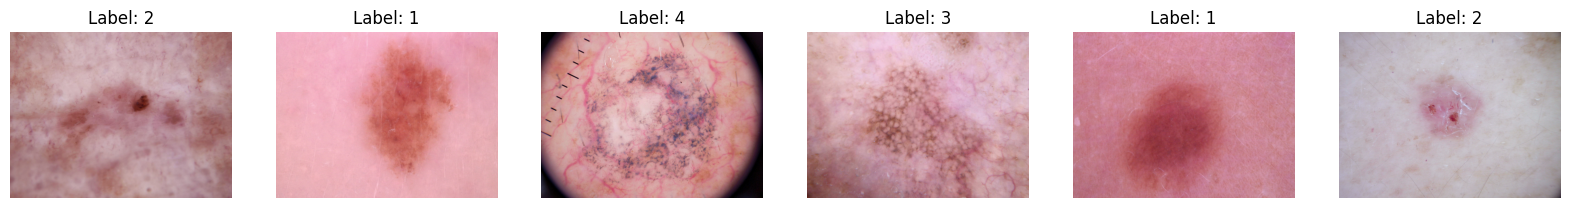

In [31]:
# Define the directory containing the training images
training_image_directory = "ISIC2018_Task3_Training_Input"

# Specify the file containing annotations for the balanced training dataset
balanced_training_annotations_file = "balanced_data.csv"

# Create an instance of the ISIC2018Dataset class for the training dataset
training_dataset = ISIC2018Dataset(img_dir=training_image_directory, annotations_file=balanced_training_annotations_file, transform=transforms.ToTensor())

def show_images(dataset, num_images=6):
    """
    Display a random sample of images from the dataset.

    Args:
        dataset (Dataset): The dataset from which to sample images.
        num_images (int): The number of images to display.
    """
    # Create a figure with multiple subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    
    # Generate random indices to select images from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    
    # Iterate over the selected indices and display the corresponding images
    for i, ax in enumerate(axes.flat):
        # Get the image and its corresponding label from the dataset
        image, label = dataset[indices[i]]
        
        # Display the image on the current subplot
        ax.imshow(image.permute(1, 2, 0))  # Permute dimensions for correct display
        ax.set_title(f'Label: {label}')  # Set title with the image label
        ax.axis('off')  # Turn off axis ticks and labels
        
    # Show the figure containing the images
    plt.show()

# Define the image transformation pipeline
image_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

# Display a sample of images from the training dataset
show_images(training_dataset, num_images=6)

#### Load Data

In [32]:
# Define the image transformation pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values
])

# Training set
training_image_directory = "ISIC2018_Task3_Training_Input"  # Directory containing training images
training_annotations_file = "balanced_data.csv"  # File containing annotations for the training set
training_dataset = ISIC2018Dataset(img_dir=training_image_directory, annotations_file=training_annotations_file, transform=image_transform)

# Validation set
validation_image_directory = "ISIC2018_Task3_Validation_Input"  # Directory containing validation images
validation_annotations_file = "ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"  # File containing annotations for the validation set
validation_dataset = ISIC2018Dataset(img_dir=validation_image_directory, annotations_file=validation_annotations_file, transform=image_transform)

# Data loaders
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=256, shuffle=False)  # DataLoader for validation set
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=256, shuffle=True)  # DataLoader for training set


## Hyperparameters

In [33]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Initialize the ResNet-18 model with pretrained weights
model = models.resnet18(pretrained=True)

# Modify the fully connected layer to have 7 output classes
model.fc = nn.Linear(model.fc.in_features, 7) 

# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW optimizer with a learning rate of 3e-5)
optimizer = optim.AdamW(model.parameters(), lr=3e-5)


Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Load

In [34]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=200, patience=10):
    best_validation_loss = float('inf')  # Initialize the best validation loss to infinity
    early_stopping_counter = 0  # Initialize the early stopping counter

    # Iterate over each epoch
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize the running loss for the current epoch

        # Iterate over each batch in the training data loader
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the appropriate device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            running_loss += loss.item()  # Accumulate the running loss

        # Validation phase
        validation_loss = 0.0  # Initialize the validation loss for the current epoch
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking during validation
            # Iterate over each batch in the validation data loader
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the appropriate device
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate the loss
                validation_loss += loss.item()  # Accumulate the validation loss

        validation_loss /= len(val_loader)  # Compute the average validation loss
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Val Loss: {validation_loss}')

        # Check if the current validation loss is better than the previous best validation loss
        if validation_loss < best_validation_loss:
            print(f'Validation loss decreased from {best_validation_loss} to {validation_loss}. Saving model...')
            best_validation_loss = validation_loss  # Update the best validation loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model's state dictionary
            early_stopping_counter = 0  # Reset the early stopping counter
        else:
            early_stopping_counter += 1  # Increment the early stopping counter
            # Check if early stopping criterion is met
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")  # Display a message indicating early stopping
                break  # Exit the training loop if early stopping criterion is met


### Model Training

In [35]:
# Set to True when you want to retrain the network, otherwise set to False to skip training
retrain_model = False

# If retraining is enabled
if retrain_model:
    # Call the train_model function to train the model
    train_model(model, criterion, optimizer, training_loader, validation_loader)


# Evaluation

In [36]:
# Load the best model's state dictionary onto the appropriate device
best_model_state_dict = torch.load('best_model.pth', map_location=device)

# Load the best model's state dictionary into the model
model.load_state_dict(best_model_state_dict)

# Set the model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
# Define the directory containing the test images
test_image_directory = "ISIC2018_Task3_Test_Input"

# Specify the file containing annotations for the test dataset
test_annotations_file = "ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

# Create an instance of the ISIC2018Dataset class for the test dataset
test_dataset = ISIC2018Dataset(img_dir=test_image_directory, annotations_file=test_annotations_file, transform=image_transform)

# Data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def evaluate_model(model, data_loader):
    true_labels = []  # List to store true labels
    predicted_labels = []  # List to store predicted labels
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking during evaluation
        # Iterate over batches in the data loader
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # Move inputs to the appropriate device
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted labels
            true_labels.extend(labels.cpu().numpy())  # Append true labels to the list
            predicted_labels.extend(preds.cpu().numpy())  # Append predicted labels to the list
    
    return true_labels, predicted_labels  # Return true labels and predicted labels

# Evaluate the model on the test dataset
true_labels, predicted_labels = evaluate_model(model, test_loader)


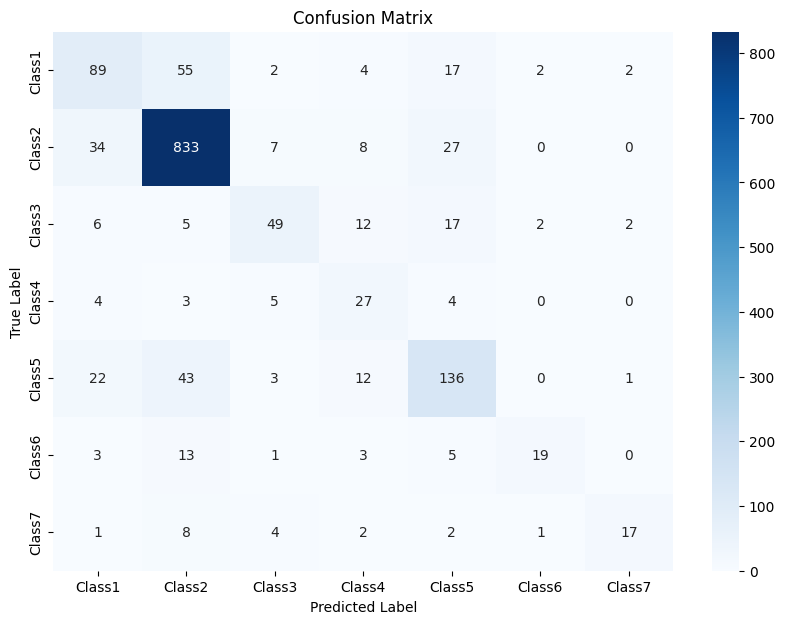

In [39]:
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, class_names):
    """
    Plot a confusion matrix.

    Args:
        confusion_matrix (ndarray): The confusion matrix to be plotted.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(10, 7))  # Set the figure size
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)  # Plot the heatmap
    plt.title('Confusion Matrix')  # Set the title of the plot
    plt.ylabel('True Label')  # Set the label for the y-axis
    plt.xlabel('Predicted Label')  # Set the label for the x-axis
    plt.show()  # Show the plot

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define the class names
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7']

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)


In [40]:
# Initialize an empty list to store predicted probabilities
predicted_probabilities = []

# Set the model to evaluation mode
model.eval()

# Iterate over batches in the test data loader
with torch.no_grad():  # Disable gradient tracking during inference
    for inputs, _ in test_loader:
        inputs = inputs.to(device)  # Move inputs to the appropriate device
        outputs = model(inputs)  # Forward pass
        probabilities = torch.softmax(outputs, dim=1)  # Compute class probabilities using softmax
        predicted_probabilities.extend(probabilities.cpu().numpy())  # Append predicted probabilities to the list


In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_classes = 7  # Number of classes in the dataset
true_labels_binarized = label_binarize(test_dataset.img_labels.iloc[:, 1:].values, classes=range(num_classes))  # Binarize the true labels
predicted_probabilities = np.array(probabilities)  # Convert predicted probabilities to a numpy array

# Initialize dictionaries to store false positive rate (FPR) and true positive rate (TPR) for each class
false_positive_rate = dict()
true_positive_rate = dict()

# Initialize dictionary to store ROC AUC (Area Under the Curve) for each class
roc_auc = dict()

# Compute ROC curve and ROC AUC for each class
for i in range(num_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])


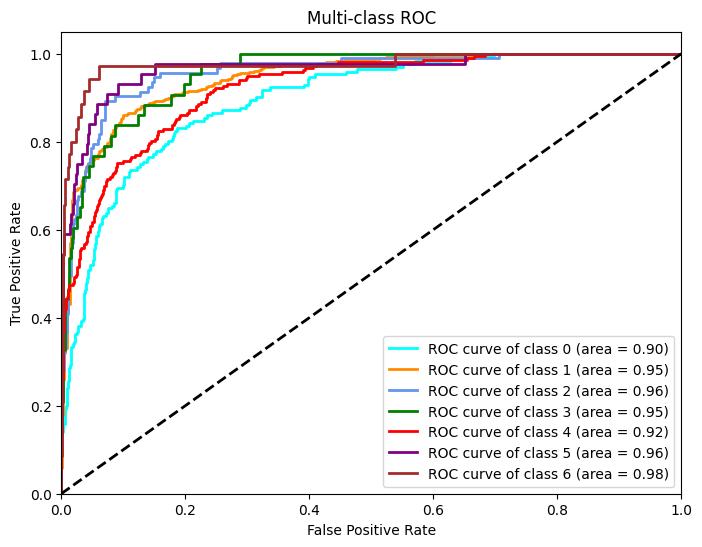

In [42]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

In [43]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Calculate accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print("Overall Accuracy:", overall_accuracy)

# Generate classification report
classification_report_str = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(classification_report_str)

# Calculate F1 score
f1_score_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_score_macro = f1_score(true_labels, predicted_labels, average='macro')
print("F1 Score (Micro):", f1_score_micro)
print("F1 Score (Macro):", f1_score_macro)


Overall Accuracy: 0.7738095238095238
Classification Report:
              precision    recall  f1-score   support

      Class1       0.56      0.52      0.54       171
      Class2       0.87      0.92      0.89       909
      Class3       0.69      0.53      0.60        93
      Class4       0.40      0.63      0.49        43
      Class5       0.65      0.63      0.64       217
      Class6       0.79      0.43      0.56        44
      Class7       0.77      0.49      0.60        35

    accuracy                           0.77      1512
   macro avg       0.68      0.59      0.62      1512
weighted avg       0.77      0.77      0.77      1512

F1 Score (Micro): 0.7738095238095238
F1 Score (Macro): 0.615734560966055
